## Mostly Harmless Convolutions and Convolutional Neural Networks (CNNs)

Author: *Kaiyan Zhang, PRAXIS UBC Team*

Date: 2025-06

### Part I: Introduction to Convolutions (in a Mostly Harmless Way)

<img src="data/convolution-operation-diagram.png" alt="A visualization of convolution operation" width="500"/>

#### Why Convolutions? 

Mathematically speaking, **Convolution** is an operation that combines two functions to produce a third function, which has a variety of applications in signal processing, image analysis and more. While this may sound complex, we can skip the mathematical parts of it and explain it in a less harmful and vivid way to our precious audiences (which is YOU). 

Let's begin by imagining a simple scenario: you took a picture of a cute dog, and you want to apply a filter to it so that it looks more vibrant and colorful. Now that you input the image into a computer, how does a computer "see" the image? The computer would see the image as a grid of numbers, where the combination of 3 numbers (R, G, B) in a grid represents the color of a pixel, and with all the colored pixels combined, it forms the image. Given the numeric nature of a computer image, we say that the image is digitalized.

Here, let's read in the image into Python and display it using `matplotlib`:


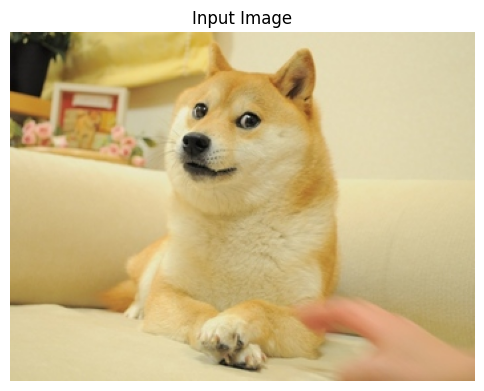

In [ ]:
# Load necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Read the image in BGR format
doge_bgr = cv2.imread('data/Original_Doge_meme.jpg')

doge_rgb = cv2.cvtColor(doge_bgr, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(doge_rgb)
plt.axis('off')  
plt.title('Input Image')
plt.show()

There is no doubt this is a cute dog, but it doesn't look like numbers, does it? In fact, if we zoom in close enough, we can clearly see that the image is made up of a grid of pixels. But we still don't see the numbers, this is because the numerical information is decoded by the computer and displayed as a colored pixel. However, we can easily convert the image into a numerical representation.

For demonstration purpose (also to protect our CPUs), I rescale the image to a 10 $\times$ 10 grid, where within each cell, the tuple represents the RGB values (0-255) of each pixel. Note that compressing images to a smaller size is always easier comparing to enhancing images to a larger size, as compression can be done by going through the image pixel by pixel and averaging the color values in each cell, while enhancement usually requires more complex operations. This gives us a hint on why convolution is important. 

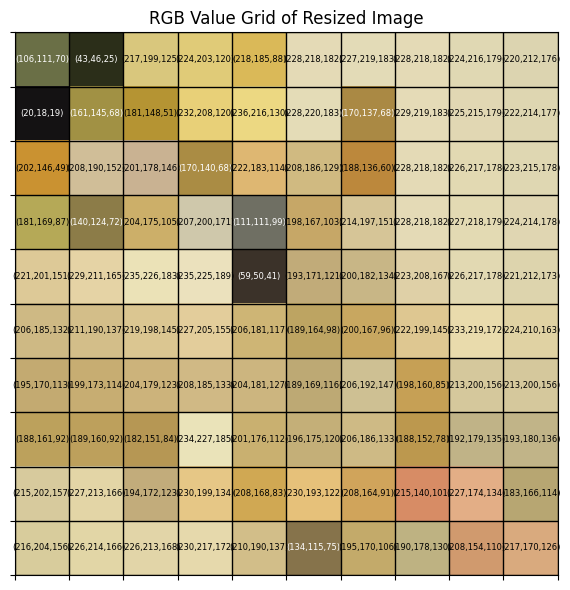

In [ ]:
img_rgb = cv2.resize(doge_rgb, (10, 10), interpolation=cv2.INTER_NEAREST)

# Plot the RGB matrix
fig, ax = plt.subplots(figsize=(6, 6))


h, w = img_rgb.shape[:2]
ax.imshow(img_rgb, extent=[0, w, h, 0]) 

# Set ticks to show grid at pixel boundaries
ax.set_xticks(np.arange(0, w + 1, 1))
ax.set_yticks(np.arange(0, h + 1, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='black', linewidth=1)

for i in range(h):
    for j in range(w):
        r, g, b = img_rgb[i, j]
        brightness = int(r) + int(g) + int(b)
        color = 'white' if brightness < 380 else 'black'
        ax.text(j + 0.5, i + 0.5, f'({r},{g},{b})',
                ha="center", va="center", fontsize=6, color=color)
        
        
# Display the Grid
ax.set_title("RGB Value Grid of Resized Image")
plt.tight_layout()
plt.show()

This has become a little abstract. Can you still identify the original image out of it? 

While the resized image may not look as cute as the original one, it still contains the necessary information, and same ideas also transits to larger images. That is, all images can be represented as a grid of numbers, where the 3 numbers in each cell corresponds to the color of a pixel. Computers can't see colors like we do, the way they see colors is as if they were mixing colors using a palette that only has red, green and blue (**RGB**), where each color has an "amount" of intensity between 0 and 255. With the 3 values for red, green and blue, computers can create any color we see in the world.

Back to the dog picture, it is easy to see that resizing the image to a smaller grid loses a lot of details, especially the rich color that makes the image vibrant. Alternatively, if we want to keep the complete color information, we can also plot out the distribution of the RGB values and frequencies in the image using a histogram. While this gives us a good idea of the color distribution, it does not tell us much about the spatial relationships between the pixels.

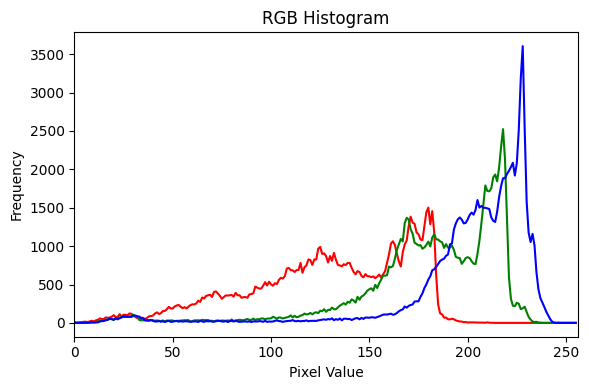

In [ ]:
# Compute and plot the color histogram
colors = ('r', 'g', 'b')
plt.figure(figsize=(6, 4))

for i, col in enumerate(colors):
    hist = cv2.calcHist(
        images=[doge_bgr],       # source image (still in BGR)
        channels=[i],           # which channel: 0=B, 1=G, 2=R
        mask=None,              
        histSize=[256],         
        ranges=[0, 256]         
    )
    plt.plot(hist, color=col)
    plt.xlim([0, 256])
    
# Display the histogram
plt.title('RGB Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Can you still identify the original image out of it? 

The example above shows us what images are like in the eyes of a computer. Computers do not understand images in the same way that humans do, they can only see them as a collection of numbers. It thus make sense that we need to apply some math to these numbers to either **change the image** or **extract some useful information** from it, and that's where convolution comes in.



#### How Does Convolution Work?

Before we dive into the application of it, let's first understand how convolution operate on an image in a more intuitive way:

Imagine you are copying a painting, you first made a draft of the same size against the original painting and now you want to color it. Other than making your painting a 100% identical copy, you want to add some personal touch to it, so you decide to use a brush with a specific pattern to color the draft. Wherever you apply the brush, it will color the region it touches with a brighter color than the original painting, and your color your draft from left to right, top to bottom, until the whole draft is colored with the brush. You end up with a new painting that is similar to the original one, but with a different style.

Here, the brush you used is called a **kernel** in the context of convolution, and the process of applying the brush is what we call **convolution operation**. We would define the kernel as a small matrix of numbers that represents the pattern of the brush, and the convolution operation as the process of transforming the original image by applying the kernel to it.

Here is a gif that illustrates how our filter (the kernel) will work on the image. You can see it as the small brush that slides over the image, operating on a small region of the image at a time, and eventually producing a new image that was completely transformed by the filter.

![Convolution Example](data/sharpener_kernel.gif)

Now, let's return to the example of the cute dog picture. What we are going to apply is a kernel called **sharpening filter**, it is a 3 $\times$ 3 matrix that looks like this:

$$\begin{bmatrix}
 0 &-1 & 0 \\
-1 & 5 & -1 \\
 0 & -1 & 0 
\end{bmatrix}$$
**Don't panic** as we are not going to do any math here, we will just let the computer do the math for us. The only thing you need to know is that this kernel will enhance the edges of the image, making it look sharper and more defined. In fact, if you take a closer look at the kernel, you will see that it has a positive value in the center and negative values around it, and it has 0 values on the corners. This exactly looks like a brush that enhances the center of a region while reducing the intensity of the surrounding pixels, which is exactly what we want to achieve with the filter.

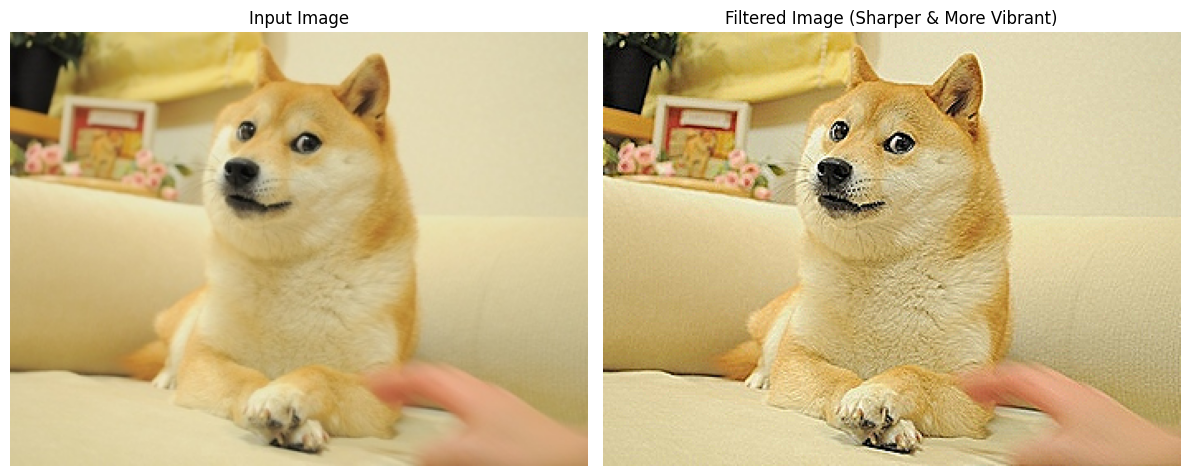

In [4]:
# Define the sharpening filter
kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)

# Apply the kernel to the color image using filter2D.
filtered = cv2.filter2D(doge_rgb, ddepth=-1, kernel=kernel)

filtered = np.clip(filtered, 0, 255).astype(np.uint8)

# Display the original and filtered images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Input
ax1.imshow(doge_rgb)
ax1.set_title("Input Image")
ax1.axis("off")

# Output
ax2.imshow(filtered)
ax2.set_title("Filtered Image (Sharper & More Vibrant)")
ax2.axis("off")

plt.tight_layout()
plt.show()

I guess the difference is quite obvious now, right? The sharpened image has more contrast and the edges are more defined, making it look more vibrant and colorful. This is the power of convolution, it allows us to apply filters to images and transform them in a way that is not possible with simple pixel manipulation.

However, convolution on image is not limited to filtering, it can also be used to **extract features** from the image. For example, we can use a kernel to detect edges, lines and texts in images, we can even use specific kernels to detect specific shapes or patterns in images, for example, a kernel that detects anything that looks like a dog. As you can imagine, this is a very powerful tool that can be used in many applications, in fact, even you have already used it in your daily life. For example, when you use a photo editing app to apply a filter to your picture, the app is using convolution to apply the filter to the image. When you use a search engine to search for images, the search engine is using convolution to extract features from the images and match them with your search query. Below is a gif showing how a convolution kernel detects "eyes" in an image:

<img src="data/eye_detection_kernel.gif" alt="A visualization of convolution operation that detects a feature" width="600"/>

This is avery simple example, and it is implemented exactly the same way as we did with the sharpening filter. The only difference is that to extract a specific features, we need to use a specific kernel that is designed to detect that feature, which usually requires some knowledge of the feature we want to extract. For example, if we want to detect eyes in the painting, we would need our "brush" to understand what eyes look like and what typical colors they have. This could be way too complicated for a single "brush", so we often use multiple brushes to detect different features when it comes to the task of feature extraction. 

To demonstrate how convolution extracts a specific feature from an image, let's take a look at a different "art tool". Let's say this time you don't want to color the painting differently, but rather you want to sketch a line art based on the original painting. You would use a fineliner pen that can detect the edges of the painting and draw a line along them. In the eyes of a computer, these are the tools it is going to use for the art:

$$\text{Horizontal Kernel} = \begin{bmatrix}
 1 & 0 & -1 \\
 2 & 0 & -2 \\
 1 & 0 & -1
\end{bmatrix} 
\text{, }
\text{Vertical Kernel} = \begin{bmatrix}
 1 & 2 & 1 \\
 0 & 0 & 0 \\
 -1 & -2 & -1
\end{bmatrix} 
$$

Still, **don't panic**, we won't do any math in this notebook. All you need to know is these two kernels together are called **Sobel filter**, and what they do is to highlight the edges in the image, making them more visible. If you take a closer look at the kernels, you will see that the first one has positive values on the left and negative values on the right, while the second one has positive values on the top and negative values on the bottom. This pattern intuitively tells us that the first "pen" will scan through the image horizontally and extract the horizontal edges, while the second "pen" will scan through the image vertically and extract the vertical edges. 

Let's now look at a different example and see what happens when we apply the Sobel filter.

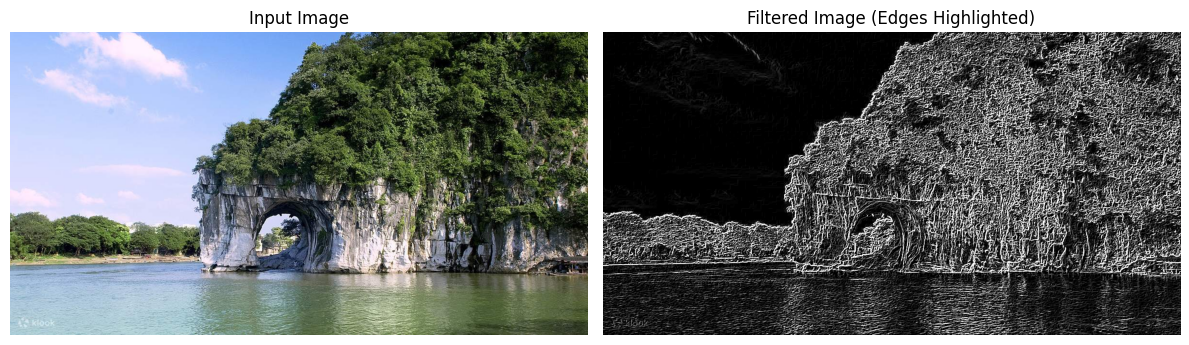

In [5]:
# Generate a greyscale version of the image
hill_bgr = cv2.imread('data/xiangbishan.jpg')

hill_rgb = cv2.cvtColor(hill_bgr, cv2.COLOR_BGR2RGB)

hill_gray = cv2.cvtColor(hill_bgr, cv2.COLOR_BGR2GRAY)

# Define the Sobel filter kernel
sb_kernel_h = np.array([
    [ 1, 0, -1],
    [ 2, 0, -2],
    [ 1, 0, -1]
], dtype=np.float32)

sb_kernel_v = np.array([
    [ 1, 2, 1],
    [ 0, 0, 0],
    [-1, -2, -1]], dtype=np.float32)

# Apply the kernel to the color image using filter2D.
horiz = cv2.filter2D(hill_gray, -1, sb_kernel_h)

vert = cv2.filter2D(hill_gray, -1, sb_kernel_v)

combined = cv2.convertScaleAbs(np.sqrt(vert.astype(np.float32)**2 + horiz.astype(np.float32)**2))

# Display the original and filtered images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Input
ax1.imshow(hill_rgb)
ax1.set_title("Input Image")
ax1.axis("off")

# Output
ax2.imshow(combined, cmap = 'gray')
ax2.set_title("Filtered Image (Edges Highlighted)")
ax2.axis("off")

plt.tight_layout()
plt.show()

As we can see in the example above, the Sobel filter detects the edges in the image and highlights them like a fineliner pen. This is a very useful technique in image processing, as it allows us to extract features from the image that can be used for further analysis or classification. More importantly, convolution is very efficient, as it is easy for computers to understand and process, and it can be applied to images of any size without losing any information. This is why convolution has become a fundamental operation in computer vision and image processing. 

But as you have probably aware, implementing convolution from scratch can be quite tedious, especially when we need to perform more specific tasks such as detecting texts or some specific shapes. To protect the brains of computer scientists, a more advanced, adaptable and efficient way of applying convolution has been developed, which is called **Convolutional Neural Networks (CNNs)**, and we will discuss it in the next part of this notebook, hopefully in a way that also protects your brain.

#### Key takeaways from this part:

- Computers see images as grids of numbers, where each grid cell contains the RGB values of a pixel. With the spatial relationships and the color information, computers can understand images without losing information.
- **Convolution** is an operation that applies a filter (kernel) to an image, transforming it in a way that enhances certain features or extracts useful information. It is like using a brush to color a painting or a pen to sketch a line art.
- The kernel that sharpens an image is called a **sharpening filter**, which enhances the edges of the image and makes it look more vibrant. The kernel that detects edges is called **Sobel filter**, which highlights the edges in the image and makes them more visible.
- Convolution is a powerful tool that can be used in many applications, such as photo editing, image search and feature extraction. It is efficient and can be applied to images of any size without losing information.


### Part II. Introduction to Convolutional Neural Networks (CNNs) (Hopefully Not Too Harmful)


<img src="data/CNN_example.jpg" alt="A visual explanation of CNN" width="800"/>

#### What are Neural Networks?

What is the first thing that comes to your mind when you hear the word "**neural network**"? If you are thinking about the human brain and neurons, you are not wrong. In fact, the term "neural network" is inspired by the way how human brain and nervous systems work, where neurons are connected to each other and communicate with each other to process information. 

In the context of **machine learning**, a neural network, or more precisely, an **artificial neural network (ANN)** is defined as "a program, or model, that makes decisions in a manner similar to the human brain, by using processes that mimic the way biological neurons work together to identify phenomena, weigh options and arrive at conclusions".



### References

- Wikipedia. Convolution <https://en.wikipedia.org/wiki/Convolution>
- IBM. What is a neural network? <https://www.ibm.com/think/topics/neural-networks>
- IBM. What are convolutional neural networks? <https://www.ibm.com/think/topics/convolutional-neural-networks>

